In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
directory = "data/mnist_images_csv/"
df = pd.read_csv(directory + "train.csv")
# df=pd.read_csv("data/mnist_images_csv/train.csv")

file_paths = df["file_name"].values 
print(file_paths)   
labels = df["label"].values
print(labels)
ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
print(ds_train)


['0_1.jpeg' '0_2.jpeg' '0_3.jpeg' '0_4.jpeg' '0_5.jpeg' '1_1.jpeg'
 '1_2.jpeg' '1_3.jpeg' '1_4.jpeg' '1_5.jpeg' '2_1.jpeg' '2_2.jpeg'
 '2_3.jpeg' '2_4.jpeg' '2_5.jpeg' '3_1.jpeg' '3_2.jpeg' '3_3.jpeg'
 '3_4.jpeg' '3_5.jpeg' '4_1.jpeg' '4_2.jpeg' '4_3.jpeg' '4_4.jpeg'
 '4_5.jpeg' '5_1.jpeg' '5_2.jpeg' '5_3.jpeg' '5_4.jpeg' '5_5.jpeg'
 '6_1.jpeg' '6_2.jpeg' '6_3.jpeg' '6_4.jpeg' '6_5.jpeg' '7_1.jpeg'
 '7_2.jpeg' '7_3.jpeg' '7_4.jpeg' '7_5.jpeg' '8_1.jpeg' '8_2.jpeg'
 '8_3.jpeg' '8_4.jpeg' '8_5.jpeg' '9_1.jpeg' '9_2.jpeg' '9_3.jpeg'
 '9_4.jpeg' '9_5.jpeg']
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]
<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [3]:
image1=df.iloc[0,0]
img=Image.open(directory+image1)
img.show()
print(image1)
# print(image1)

0_1.jpeg


In [4]:
df.head(3)

,file_name,label
0,0_1.jpeg,0
1,0_2.jpeg,0
2,0_3.jpeg,0


In [5]:
# #trying out decoding single image
# img=df.iloc[0,0]
# lbl=df.iloc[0,1]
# print(img,lbl)

# img=tf.image.decode_image(img,channels=1,dtype=tf.float32)
# print("after decoding",img)

In [6]:
def read_image(image_file, label):
    full_path=directory+image_file
    print(full_path)
    image = tf.io.read_file(full_path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    return image, label

In [7]:
# #let's use the above function
# for element in ds_train:
#     file_path, label=element
#     nimg,nl=read_image(file_path,label)
#     nimg_np=nimg._numpy()
#     nimg_np=nimg_np.reshape(28,28)
#     nimg_pil=nimg_np=Image.fromarray(nimg_np)
#     nimg_pil.show()



In [8]:
def augment(image, label):
    # data augmentation here
    return image, label

In [9]:
ds_train = ds_train.map(read_image).map(augment).batch(2)

Tensor("add:0", shape=(), dtype=string)


In TensorFlow, when you chain multiple .map() operations together, each operation applies to the output of the previous one. In this case, ds_train.map(read_image) first maps the read_image function to each element of the dataset, and then ds_train.map(augment) maps the augment function to the results of the previous mapping. Finally, .batch(2) batches the elements in groups of 2.

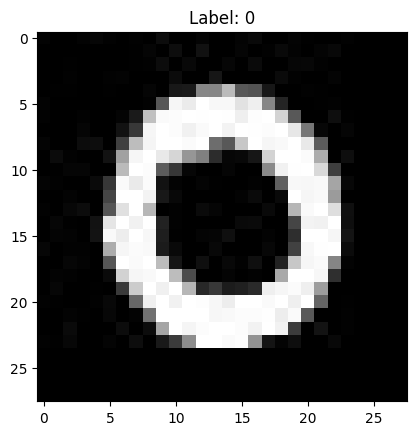

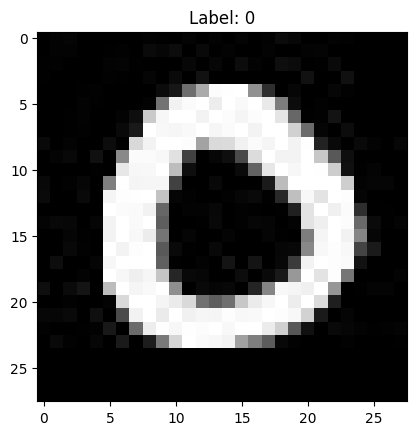

In [10]:
# Print and display some decoded images
for image_batch, label_batch in ds_train.take(1):  # Take the first batch
    for i in range(len(image_batch)):
        image = image_batch[i].numpy()
        label = label_batch[i].numpy()
        
        # Display the image and label 
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.show()

In [11]:
# checking if the dataset is empty or not
dataset_size = tf.data.experimental.cardinality(ds_train).numpy()
if dataset_size == 0:
    print("The dataset is empty.")
else:
    print("The dataset contains", dataset_size, "elements.")

The dataset contains 25 elements.


In [12]:
print(ds_train)
print(ds_train.element_spec)


<_BatchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [14]:
# for epoch in range(10):
#     for x, y in ds_train:
#         print("Image shape:", x.shape)
#         print("Label:", y)

In [15]:
model = keras.Sequential(
    [
        layers.Input((28, 28, 1)),
        layers.Conv2D(16, 3, padding="same",activation="relu"),
        layers.Conv2D(32, 3, padding="same",activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(10),
    ]
)

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 10)                62730     
                                                                 
Total params: 67530 (263.79 KB)
Trainable params: 67530 (263.79 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
    metrics=["accuracy"],
)


In [18]:
model.fit(ds_train, epochs=10, verbose=2)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1031]